<a href="https://colab.research.google.com/github/michaelachmann/social-media-lab/blob/main/notebooks/2024_11_18_Simple_Corpus_Analysis_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Corpus Analysis [![DOI](https://zenodo.org/badge/660157642.svg)](https://zenodo.org/badge/latestdoi/660157642)
![Notes on (Computational) Social Media Research Banner](https://raw.githubusercontent.com/michaelachmann/social-media-lab/main/images/banner.png)

## Overview

This Jupyter notebook is a part of the social-media-lab.net project, which is a work-in-progress textbook on computational social media analysis. The notebook is intended for use in my classes.

The **Simple Corpus Analysis** Notebook introduces simple natural language processing tools for counting frequencies and wordclouds. Parts of this notebook are taken from work by [Jakob Fehle](https://www.uni-regensburg.de/sprache-literatur-kultur/medieninformatik/sekretariat-team/jakob-fehle/index.html).

**2024 Updates**
* Added a new data sample from the US 2024 Elections
* Replaced German with English stopword list
* Added grouping to the end of the document: Use Wordclouds to explore group differences.

### Project Information

- Project Website: [social-media-lab.net](https://social-media-lab.net/)
- GitHub Repository: [https://github.com/michaelachmann/social-media-lab](https://github.com/michaelachmann/social-media-lab)

## License Information

This notebook, along with all other notebooks in the project, is licensed under the following terms:

- License: [GNU General Public License version 3.0 (GPL-3.0)](https://www.gnu.org/licenses/gpl-3.0.de.html)
- License File: [LICENSE.md](https://github.com/michaelachmann/social-media-lab/blob/main/LICENSE.md)


## Citation

If you use or reference this notebook in your work, please cite it appropriately. Here is an example of the citation:

```
Michael Achmann. (2024). michaelachmann/social-media-lab: 2024-11-18 (v0.0.14). Zenodo. https://doi.org/10.5281/zenodo.8199901
```

## 1. Import Data

In [16]:
#@markdown Read the `csv` file. Select the correct `text_column` below. We called this column `Text` in our **Text Master** table (see [Preprocessing Notebook](https://github.com/michaelachmann/social-media-lab/blob/main/notebooks/2024_11_11_Preprocessing.ipynb) and [OCR & Whisper Documentation](https://social-media-lab.net/processing/preprocessing.html#ocr-whisper)). When using raw data from i.e. **4CAT / Zeeschuimer** the Instagram caption column is called `body`, in **Meta Content Library Exports** it is `text`.

import pandas as pd

csv_file = "/content/drive/MyDrive/2024-11-18-US-Sample.csv" #@param {type:"string"}
text_column = "text" #@param {type:"string"}


df = pd.read_csv(csv_file)

*Note:* The data used in this tutorial has been retrieved through the Meta Content Library [1]. Snippets shown are for demonstration purposes only, while the datasets are part of my ongoing research.

[1] Meta Platforms, Inc. (n.d.). Meta Content Library API version v5.0. https://doi.org/10.48680/meta.metacontentlibraryapi.5.0


In [21]:
df[['text', 'creation_time', 'hashtags', 'Export Group']].head()

,text,creation_time,hashtags,Export Group
0,🚨Did I hear that right!? \n\n𝔀𝔀𝔀.𝓢𝓮𝓪𝓞𝓯𝓜𝓾𝓭.𝓬𝓸𝓶\...,2024-11-05T14:59:20-08:00,"[""trumprally2024"",""kamunism"",""harriswalz2024"",...",Trump
1,New ‘Kamalexa’ Amazon Echo Rambles And Never A...,2024-11-05T14:59:03-08:00,"[""election"",""trump"",""harris""]",Trump
2,🩸🇺🇸🦅 BLOOD OF JESUS CLEAN THE STREETS OF OUR N...,2024-11-05T14:58:11-08:00,"[""kamala"",""kamalaharris"",""usa"",""trump2024"",""tr...",Trump
3,#Trump #Republicans #MAGA #TrumpSupporters #GO...,2024-11-05T14:58:02-08:00,"[""election"",""gop"",""rightwing"",""usa"",""republica...",Trump
4,Make America $CHILL Again 🫡\n\n#LumiChill #Tru...,2024-11-05T14:57:56-08:00,"[""trump2024"",""trump"",""lumichill""]",Trump


## Analyzing Corpus and Word Frequencies

Among a variety of possibilities, we can, for example, look at the frequencies of the words contained in the corpus or examine the corpus for recurring themes it contains.

First we need to import all the required libraries once again.
The [Natural Language Toolkit (NLTK)](https://www.nltk.org/howto.html) gives us access to a variety of natural language processing functions (e.g. tokenisation, stop word removal, part-of-speech tagging, ...).

In [23]:
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import requests
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


When analysing word frequencies, we can use stop word lists to ignore words that occur frequently but are not relevant to us. We can easily download such a list. However, this can also be individually adapted to the purpose.

In [32]:
# Retrieve GERMAN Stopwords from Github
# sw_json = requests.get('https://github.com/stopwords-iso/stopwords-de/raw/master/stopwords-de.json')

# Retreive ENGLISH Stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now we can tokenise the existing text, remove the stop words or punctuation marks they contain, convert the words to lower case, or use bi-grams in addition to single-word tokens.

We then sum up the occurrences of the individual words and make the results available in a DataFrame.

In [50]:
def word_freq(text, punctuation=False, stop_words = False, lowercasing = False, bigrams = False):

    if punctuation:
        # Tokenizing, removing punctuation
        tokens = RegexpTokenizer(r'\w+').tokenize(text) # https://regexr.com/
    else:
        # Tokenizing, w/o removing punctuation
        # tokens = text.split()
        tokens = word_tokenize(text)

    if stop_words:
        # Removing Stopwords
        tokens = [w for w in tokens if not w.lower() in stop_words]

    if lowercasing:
        # Lower-Casing
        tokens = [w.lower() for w in tokens]

    if bigrams:
        # Converting text tokens into bigrams
        tokens = nltk.bigrams(tokens)

    # Creating Data Frame
    freq = nltk.FreqDist(tokens) # display(freq)
    df = pd.DataFrame.from_dict(freq, orient='index')
    df.columns = ['Frequency']
    df.index.name = 'Term'

    # Here we calculate the total number of tokens in our Frequency List
    total_tokens = sum(freq.values()) # sum([2,3,4,5,6])

    # Here we add a new column `Relative` (*100 for percentage)
    df['Relative'] = (df['Frequency'] / total_tokens) * 100

    return df

In [51]:
from pathlib import Path
import os

#@markdown Do you want bigrams included?
bigrams = True #@param {type:"boolean"}

#@markdown Should all words get lower cased before counting the occurances?
lowercasing = True #@param {type:"boolean"}

#@markdown Do you want to exclude stopwords in your result list?
remove_stopwords = True #@param {type:"boolean"}

#@markdown Do you want to remove punctuation before counting the occurances?
punctuation = True #@param {type:"boolean"}

In [52]:
from nltk.corpus import stopwords

# Let's filter the df to exclude any rows without captions
filtered_df = df[~pd.isna(df[text_column])]

# Load stopwords file if necessary
if remove_stopwords:
  # UNCOMMENT FOR GERMAN STOPWORD LIST
  # stop_words = sw_json.json()
  stop_words = set(stopwords.words('english'))

# Read source file and concat all texts
text = ' '.join(list(filtered_df[text_column]))

# Call word_freq() with specified parameters
df_freq = word_freq(text, punctuation = punctuation, stop_words = stop_words, lowercasing = lowercasing, bigrams = bigrams)

# Sort results for descending values
df_freq = df_freq.sort_values("Relative", ascending = False)

display(df_freq[0:10])

,Frequency,Relative
Term,,
"(trump, harris)",1736,0.430616
"(donald, trump)",1546,0.383487
"(kamala, harris)",1393,0.345535
"(redacted_mention, redacted_mention)",1175,0.291460
"(link, bio)",1154,0.286251
"(harris, trump)",849,0.210595
"(former, president)",664,0.164706
"(trump, kamalaharris)",636,0.157760
"(donaldtrump, trump)",594,0.147342


## Wordcloud
One way to visualise word frequencies and recurring themes of texts are word clouds. These basically show the most frequently occurring words in the text (similar to the table created earlier), but more frequently occurring words are depicted larger than less frequently occurring words.

First, we have to install the necessary library `wordcloud`.

In [39]:
!pip install -q wordcloud

The actual implementation of this approach is relatively simple. We need to combine all the texts into a single text, as we did in the previous step with the frequency analysis, and pass it to the imported library.

In [61]:
from wordcloud import WordCloud, STOPWORDS

def generate_wordcloud(text, subcaption, path):

    text = ' '.join(list(text))

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white",width=1920, height=1080).generate(text)

    # Dazugehörige Grafik erstellen
    plt.imshow(wordcloud, interpolation="bilinear") # Auflösung/Interpolation der Grafik
    plt.axis("off")
    plt.figtext(0.5, 0.1, subcaption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.savefig(path, dpi=300)
    plt.show()

Once again, we have the option of adjusting various parameters. Remember to specify the right file path, file name and column of your text data!

In [53]:
#@markdown Input for additional stopwords; whitespace separated
stopwords_extension_wc = '' #@param {type: "string"}

#@markdown Subcaption for the wordcloud, leave blank to ignore
wordcloud_subcaption = 'Whole Dataset' #@param {type: "string"}

Now all we have to do is load the stop word file, add our own additions and then trigger the creation of the word cloud using the function we created at the beginning.

The result image is saved in the defined `data_path`.

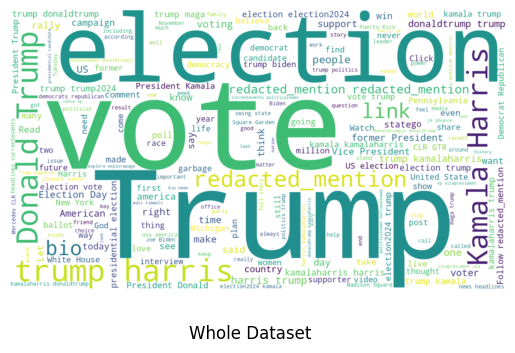

In [62]:
import matplotlib.pyplot as plt
import requests

# Convert input into list
stopwords_extension_wc_list = stopwords_extension_wc.split(' ')
stop_words.update(stopwords_extension_wc_list)

# Stopwörter in die WordCloud laden
STOPWORDS.update(stop_words)

# Let's filter the df to exclude any rows without captions
filtered_df = df[~pd.isna(df[text_column])]

generate_wordcloud(filtered_df[text_column], wordcloud_subcaption, 'wordcloud.png')

In [59]:
#@markdown Let's split the datasets and compare the wordclouds
grouping_column = 'Export Group' #@param {type: "string"}

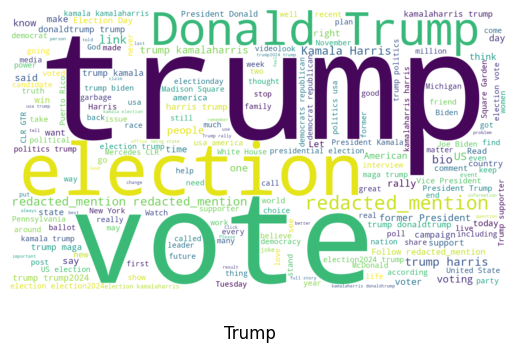

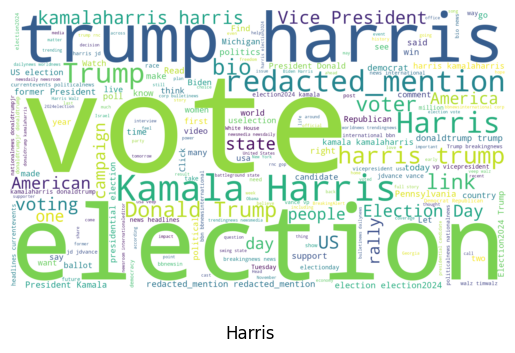

In [63]:
for group in df[grouping_column].unique():
  group_df = df[df[grouping_column] == group]
  filtered_df = group_df[~pd.isna(group_df[text_column])]

  generate_wordcloud(filtered_df[text_column], group, f'wordcloud_{group}.png')